# Exhaustive vs Heuristic

This notebook digs into the performance of the algorithm where the exhaustive is compared to the heuristic. Due to the exhaustive algorithm taking a considerable amount of time, only pooled rides with degrees up to three are considered. 

The exhaustive algorithm is first verified to see the whether all possible pudo combinations are checked for. 

In [1]:
import os
cwd = os.getcwd()
os.chdir(os.path.join(cwd,'../../..'))

In [2]:
import ExMAS.utils
import ExMAS.main
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import numpy as np
from matplotlib import collections as matcoll
from ExMAS.utils import inData as inData

In [3]:
params = ExMAS.utils.get_config('ExMAS/data/configs/ams-config-1.json') # load the default 
params.nP= 600
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
inData = ExMAS.utils.load_albatross_csv(inData, params, sample=True)


In [4]:
inData = ExMAS.main(inData, params, plot = False)


25-05-21 10:23:04-INFO-Initializing pairwise trip shareability between 600 and 600 trips.
25-05-21 10:23:04-INFO-creating combinations
25-05-21 10:23:04-INFO-359400	 nR*(nR-1)
25-05-21 10:23:13-INFO-Reduction of feasible pairs by 99.61%
25-05-21 10:23:13-INFO-Degree 2 	Completed
25-05-21 10:23:13-INFO-trips to extend at degree 2 : 2879
25-05-21 10:23:17-INFO-At degree 2 feasible extensions found out of 444 searched
25-05-21 10:23:17-INFO-Degree 3 	Completed
25-05-21 10:23:17-INFO-trips to extend at degree 3 : 444
25-05-21 10:23:18-INFO-At degree 3 feasible extensions found out of 30 searched
25-05-21 10:23:18-INFO-Degree 4 	Completed
25-05-21 10:23:18-INFO-trips to extend at degree 4 : 30
25-05-21 10:23:18-INFO-At degree 4 feasible extensions found out of 4 searched
25-05-21 10:23:18-INFO-Degree 5 	Completed
25-05-21 10:23:18-INFO-trips to extend at degree 5 : 4
25-05-21 10:23:18-INFO-At degree 5 feasible extensions found out of 1 searched
25-05-21 10:23:18-INFO-Degree 6 	Completed
25-

In [5]:
walk_speed = 1.389                     #m/s
walk_time  = 5                         #min
walk_dist  = round (walk_speed*60*5)   #metres

In [6]:
def pudo_requests(_inData, walk_speed = 1.389, walk_time = 5):
    
    walk_dist = round(walk_speed*60*5)
    
    pudo = pd.DataFrame(index = range(len(_inData.sblts.requests)), columns = ['pax_id', 'origin', 'destination', \
                               'origin_nodes','destination_nodes','origin_dist','destination_dist'])
    pudo['pax_id'] = _inData.sblts.requests['index']
    pudo['origin'] = _inData.sblts.requests['origin'].tolist()
    pudo['destination'] = _inData.sblts.requests['destination'].tolist()
    pudo = pudo.astype(object)
    for i in range(len(pudo)):
        #origins = _inData.skim[pudo.iloc[i]['origin']][(_inData.skim[pudo.iloc[i]['origin']]<walk_dist) & (_inData.skim[pudo.iloc[i]['origin']]>0)].sort_values()                 #excludes original origin as PUDO point
        origins = _inData.skim[pudo.iloc[i]['origin']][(_inData.skim[pudo.iloc[i]['origin']]<walk_dist)].sort_values()                                                             # everything in walk_dist radius
        
        #destinations = _inData.skim[pudo.iloc[i]['destination']][(_inData.skim[pudo.iloc[i]['destination']]<walk_dist) & _inData.skim[pudo.iloc[i]['destination']]>0].sort_values()
        destinations = _inData.skim[pudo.iloc[i]['destination']][(_inData.skim[pudo.iloc[i]['destination']]<walk_dist)].sort_values()
        
        pudo.at[i,'origin_nodes'] = list(origins.index)
        pudo.at[i,'destination_nodes'] = list(destinations.index)
        
        pudo.at[i,'origin_dist']  = origins.tolist()
        pudo.at[i,'destination_dist'] = destinations.tolist()
        
    _inData.pudo = pudo
    
    return _inData


In [7]:
  
def plot_map_rides(inData, ride_indexes, light=True, m_size=30, lw=3, fontsize = 10, figsize = (40,40)):
    import seaborn as sns

    from matplotlib.collections import LineCollection

    def make_schedule(t, r, p):
        columns = ['node', 'times', 'req_id','pudo_nodes', 'od']
        degree = 2 * len(t.indexes)
        df = pd.DataFrame(None, index=range(degree), columns=columns)
        x = t.indexes_orig
        s = [r.loc[i].origin for i in x] + [r.loc[i].destination for i in t.indexes_dest]
        print(s)
        p = [p.iloc[i].origin_nodes for i in x] + [p.iloc[i].destination_nodes for i in t.indexes_dest]      #retrieving pudo locs from PUDO DF
        df.node = pd.Series(s)                                                                                    # adding pudo to DF
        df.pudo_nodes = pd.Series(p)
        df.req_id = x + t.indexes_dest
        df.times = t.times
        df.od = pd.Series(['o'] * len(t.indexes) + ['d'] * len(t.indexes))
        return df


    def add_route(ax, route, color='grey', lw=2, alpha=0.5):
        # plots route on the graph alrready plotted on ax
        edge_nodes = list(zip(route[:-1], route[1:]))
        lines = []
        for u, v in edge_nodes:
            # if there are parallel edges, select the shortest in length
            data = min(G.get_edge_data(u, v).values(), key=lambda x: x['length'])
            # if it has a geometry attribute (ie, a list of line segments)
            if 'geometry' in data:
                # add them to the list of lines to plot
                xs, ys = data['geometry'].xy
                lines.append(list(zip(xs, ys)))
            else:
                # if it doesn't have a geometry attribute, the edge is a straight
                # line from node to node
                x1 = G.nodes[u]['x']
                y1 = G.nodes[u]['y']
                x2 = G.nodes[v]['x']
                y2 = G.nodes[v]['y']
                line = [(x1, y1), (x2, y2)]
                lines.append(line)
        lc = LineCollection(lines, colors=color, linewidths=lw, alpha=alpha, zorder=3)
        ax.add_collection(lc)

    s = inData.sblts.rides
    r = inData.sblts.requests
    G = inData.G
    p  = inData.pudo
    ts = [make_schedule(s.loc[ride_index],r,p) for ride_index in ride_indexes]

    # t1 = make_schedule(s.iloc[1], r)
    # t2 = make_schedule(s[s.kind == 20].iloc[1], r)
    #t3 = make_schedule(s[s.kind == 31].iloc[3], r)



    G = inData.G
    fig, ax = ox.plot_graph(G, figsize=figsize, node_size=0, edge_linewidth=0.3,
                            show=False, close=False,
                            edge_color='grey',  bgcolor='white')

    #colors = {1: 'navy', 2: 'teal', 3: 'maroon', 4: 'black', 5: 'green', 6:'teal'}
    colors = sns.color_palette("Set2",6)


    for t in ts:

        orig_points_lats, orig_points_lons, dest_points_lats, dest_points_lons = [], [], [], []
        deg = t.req_id.nunique()
        count = 0
        for i in t.req_id.unique():
            count += 1
            r = t[t.req_id == i]

            o = r[r.od == 'o'].iloc[0].node
            d = r[r.od == 'd'].iloc[0].node
            
            o_pudo = r[r.od == 'o'].iloc[0].pudo_nodes
            d_pudo = r[r.od == 'd'].iloc[0].pudo_nodes

            if not light:
                ax.annotate('o' + str(i), (G.nodes[o]['x'] * 1.0001, G.nodes[o]['y'] * 1.00001), fontsize = fontsize,
                    bbox = dict(facecolor='white', alpha=0.7, edgecolor='none'))
                ax.annotate('d' + str(i), (G.nodes[d]['x'] * 1.0001, G.nodes[d]['y'] * 1.00001), fontsize = fontsize,
                    bbox = dict(facecolor='white', alpha=0.7, edgecolor='none'))
            route = nx.shortest_path(G, o, d, weight='length')
            add_route(ax, route, color='black', lw=lw / 2, alpha=0.3)
            ax.scatter(G.nodes[o]['x'], G.nodes[o]['y'], s=m_size, c=[colors[deg]], marker='o')
            ax.scatter(G.nodes[d]['x'], G.nodes[d]['y'], s=m_size, c=[colors[deg]], marker='>')
            for o_p in o_pudo:
                ax.scatter(G.nodes[o_p]['x'], G.nodes[o_p]['y'], s=m_size,alpha = 0.8, c=[colors[deg]], marker='x')
            for d_p in d_pudo:
                ax.scatter(G.nodes[d_p]['x'], G.nodes[d_p]['y'], s=m_size,alpha = 0.8, c=[colors[deg]], marker='x')
        routes = list()  # ride segments
        o = t.node.values[0]
        for d in t.node.values[1:]:
            routes.append(nx.shortest_path(G, o, d, weight='length'))
            o = d
        for route in routes:
            add_route(ax, route, color=[colors[deg]], lw=lw, alpha=0.7)
    plt.tight_layout()
    plt.savefig('map.png', dpi = 300)

In [8]:
def ride_to_pudo_graph(ride):                                                    # function converts skim of PUDO locations between requests to a dictionary. 
    
    graph = {}                                                                   # The skim of two requests is saved in graph, ordered as indexes_origin + indexes_destination
    for i,trip_o in enumerate(ride.indexes):
        #O_0 = inData.pudo.iloc[r.indexes[0]].origin
        if i<(len(ride.indexes)-1):
            O_0 = inData.pudo.iloc[ride.indexes[i]].origin_nodes
            O_1 = inData.pudo.iloc[ride.indexes[i+1]].origin_nodes

            D_0 = inData.pudo.iloc[ride.indexes_dest[i]].destination_nodes
            D_1 = inData.pudo.iloc[ride.indexes_dest[i+1]].destination_nodes
            graph[i]  = inData.skim.loc[O_0][O_1]

            graph[i+(len(ride.indexes))] = inData.skim.loc[D_0][D_1]
        else:
            O_0 = inData.pudo.iloc[ride.indexes[-1]].origin_nodes
            D_0 = inData.pudo.iloc[ride.indexes_dest[0]].destination_nodes
            graph[i]  = inData.skim.loc[O_0][D_0]
    for i,g in enumerate(graph):
        graph[i] = graph[i].stack().sort_values()                              # sort skim distances from least to greatest
        
    return graph                                                               # Size of graph indeces is (len(indexes_origin + indexes_destination) -1)

# Two trips


In [14]:
def two_degree_pudo_exh(_graph, r):
    
    distances      = [0]*(len((r.indexes))*2-1)                                                 #Empty list to store distances between nodes, will constantly be overwritten
    nodes          = [0] *(len(r.indexes)*2)                                                                   #Empty list to store the optimal PUDO locations
    
    pred_list  = np.array([])
    dist_list  = np.array([])
    
    predecessor = [float('inf')]                                                                            #Stores the theoretical minium
    counter     = 0

    for i, d_0 in _graph[0].iteritems():                                                    # iterate through every row in graph, i is nodes and d_0 is distance between nodes      
        nodes_0 = i                                                                         # nodes are in form of [x_1,x_2] or [O,D] respectively
        distances[0]=d_0                                                                    # Save distance to list
        for j, d_1 in _graph[1].loc[i[1]].iteritems():                                      # Next trip with origin now from x_2
                                                   
            nodes_1 = j                                                                    # node is now single int value
            distances[1]= d_1                                                             

            for k, d_2 in _graph[2].loc[j].iteritems():
                
                nodes_2 = k
                distances[2]= d_2

                if sum(predecessor)> sum(distances):                                                # if distances are smaller than predecessor, copy distances to predecessor and save nodes
                    predecessor = distances.copy()
                counter = counter +1    
                dist_list = np.append(dist_list, sum(distances))
                pred_list  = np.append(pred_list,sum( predecessor))
    pred_list[0] = dist_list[0]                          
    #ttimes = list(map(lambda x: round(x/params.avg_speed), predecessor))

    return dist_list, pred_list, counter

In [15]:
def two_degree_pudo(_graph, r, limit = 10000):
    
    distances      = [0]*(len((r.indexes))*2-1)                                                 #Empty list to store distances between nodes, will constantly be overwritten
    nodes          = [0] *(len(r.indexes)*2)                                                                   #Empty list to store the optimal PUDO locations
    
    pred_list  = np.array([])
    dist_list  = np.array([])
    
    predecessor = [float('inf')]                                                                            #Stores the theoretical minium
    counter     = 0

    for i, d_0 in _graph[0].iteritems():                                                    # iterate through every row in graph, i is nodes and d_0 is distance between nodes
        if counter >= limit:                                                                #break once iteration counter reaches limit
            break        
        nodes_0 = i                                                                         # nodes are in form of [x_1,x_2] or [O,D] respectively
        distances[0]=d_0                                                                    # Save distance to list
        for j, d_1 in _graph[1].loc[i[1]].iteritems():                                      # Next trip with origin now from x_2
            if counter >= limit:
                break
                                                   
            nodes_1 = j                                                                    # node is now single int value
            distances[1]= d_1                                                             

            if sum(predecessor)< sum(distances):                                           # break loop if distance thus far is greater than total distance from predecessor
                distances[1] = 0                                                           # reset specific distance to 0
                counter = counter + 1                                                      # record iteration
                break

            for k, d_2 in _graph[2].loc[j].iteritems():
                
                nodes_2 = k
                distances[2]= d_2
                #print(sum(distances), sum(predecessor),counter)
                dist_list = np.append(dist_list, sum(distances))
                pred_list  = np.append(pred_list, sum(predecessor))
                counter = counter +1
                if sum(predecessor)< sum(distances):                                                 # eventually previous is compared to newly saved distance, if predecessor is still smaller, loop breaks
                    distances[2] = 0
                    counter = counter + 1
                    break    
                elif sum(predecessor)> sum(distances):                                                # if distances are smaller than predecessor, copy distances to predecessor and save nodes
                    predecessor = distances.copy()
                    distances[2] = 0
                    counter = counter + 1
                    break
                    
    pred_list[0] = dist_list[0]                        
    #ttimes = list(map(lambda x: round(x/params.avg_speed), predecessor))

    return dist_list, pred_list ,  counter

# Three trips


In [16]:
def three_degree_pudo_exh(_graph, r):
    
    distances      = [0]*(len((r.indexes))*2-1)                                                 #Empty list to store distances between nodes, will constantly be overwritten
    nodes          = [0] *(len(r.indexes)*2)                                                                   #Empty list to store the optimal PUDO locations
    
    pred_list  = np.array([])
    dist_list  = np.array([])
    
    predecessor = [float('inf')]                                                                            #Stores the theoretical minium
    counter     = 0

    for i, d_0 in _graph[0].iteritems():       

        nodes_0 = i                                                                                         

        distances[0]=d_0                                                                                    

 
        for j, d_1 in _graph[1].loc[i[1]].iteritems():

            nodes_1 = j

            distances[1]=d_1

                                         

            for k, d_2 in _graph[2].loc[j].iteritems():


                nodes_2 = k

                distances[2]=d_2

                for l, d_3 in _graph[3].loc[k].iteritems():                 

                    nodes_3 = l

                    distances[3]=d_3



                    for m, d_4 in _graph[4].loc[l].iteritems():

                        nodes_4 = m
                        distances[4]= d_4
                        
                        if sum(predecessor)> sum(distances):                                                # if distances are smaller than predecessor, copy distances to predecessor and save nodes
                            predecessor = distances.copy()
                        counter = counter +1    
                        dist_list = np.append(dist_list, sum(distances))
                        pred_list  = np.append(dist_list, sum(predecessor))
                            
    #ttimes = list(map(lambda x: round(x/params.avg_speed), predecessor))
    pred_list[0] = dist_list[0]
    return dist_list, pred_list, counter

In [17]:
def three_degree_pudo(_graph, r, limit = 10000):
    
    distances   = [0]*(len((r.indexes))+(len(r.indexes)-1))                                                 #Empty list to store distances between nodes, will constantly be overwritten
    nodes       = [0] *(len(r.indexes)*2)                                                                   #Empty list to store the optimal PUDO locations

    predecessor = [float('inf')]                                                                            #Stores the theoretical minium
    counter     = 0
                                                                                                            #Iteration limit
    for i, d_0 in _graph[0].iteritems():    

        if counter >= limit:

            break               

        nodes_0 = i                                                                                         

        distances[0]=d_0                                                                                    

        for j, d_1 in _graph[1].loc[i[1]].iteritems():

            if counter >= limit:

                break

            nodes_1 = j

            distances[1]=d_1

            if sum(predecessor)< sum(distances):                                                            

                distances[1] = 0                                                                            

                counter = counter + 1                                                                       

                break

            for k, d_2 in _graph[2].loc[j].iteritems():

                if counter >= limit:

                    break

                nodes_2 = k

                distances[2]=d_2

                if sum(predecessor)< sum(distances):

                    distances[2] = 0

                    counter = counter + 1

                    break

                for l, d_3 in _graph[3].loc[k].iteritems():

                    if counter >= limit:

                        break                    

                    nodes_3 = l

                    distances[3]=d_3

                    

                    if sum(predecessor)< sum(distances):

                        distances[3] = 0

                        counter = counter + 1

                        break

                    for m, d_4 in _graph[4].loc[l].iteritems():

                        nodes_4 = m

                        distances[4]= d_4

                        dist_list = np.append(dist_list, sum(distances))
                        pred_list  = np.append(pred_list, sum(predecessor))
                        counter = counter +1
                        if sum(predecessor)< sum(distances):                                                 # eventually previous is compared to newly saved distance, if predecessor is still smaller, loop breaks
                            distances[2] = 0
                            counter = counter + 1
                            break    
                        elif sum(predecessor)> sum(distances):                                                # if distances are smaller than predecessor, copy distances to predecessor and save nodes
                            predecessor = distances.copy()
                            distances[2] = 0
                            counter = counter + 1
                            break
                            
    #ttimes = list(map(lambda x: round(x/params.avg_speed), predecessor))
    pred_list[0] = dist_list[0]
    return dist_list, pred_list, counter

# Four Degree

In [18]:
def four_degree_pudo(_graph, r, limit = 10000):
    
    distances   = [0]*(len((r.indexes))+(len(r.indexes)-1))                                                 #Empty list to store distances between nodes, will constantly be overwritten
    nodes       = [0] *(len(r.indexes)*2)                                                                   #Empty list to store the optimal PUDO locations

    predecessor = [float('inf')]                                                                            #Stores the theoretical minium
    counter     = 0
                                                                                                            #Iteration limit
    for i, d_0 in _graph[0].iteritems():

        nodes_0 = i
        distances[0]=d_0
        
        for j, d_1 in _graph[1].loc[i[1]].iteritems():
   
                
            
            nodes_1 = j
            distances[1]=d_1

            
            for k, d_2 in _graph[2].loc[j].iteritems():
                
                nodes_2 = k
                distances[2]=d_2  

                    
                for l, d_3 in _graph[3].loc[k].iteritems():
                    if counter >= limit:
                        break         
                    
                    nodes_3 = l
                    distances[3]=d_3
  
                        
                    for m, d_4 in _graph[4].loc[l].iteritems():
                        if counter >= limit:
                            break 
                        
                        nodes_4 = m
                        distances[4]=d_4
 
 
                        for n, d_5 in _graph[5].loc[m].iteritems():                             
                            
                            nodes_5 = n
                            distances[5]= d_5
      
                                
                            for o, d_6 in _graph[6].loc[n].iteritems():
                                
                                nodes_6 = o
                                distances[6]=d_6
                                #print(sum(distances), sum(predecessor),counter)
                                if sum(predecessor)> sum(distances):                                                # if distances are smaller than predecessor, copy distances to predecessor and save nodes
                                    predecessor = distances.copy()
                                        
                                dist_list = np.append(dist_list, sum(distances))
                                pred_list  = np.append(dist_list, sum(predecessor))
                                counter = counter +1
                            
    #ttimes = list(map(lambda x: round(x/params.avg_speed), predecessor))
    pred_list[0] = dist_list[0]
    return dist_list, pred_list, counter

In [19]:
def four_degree_pudo(_graph, r, limit = 10000):
    
    distances   = [0]*(len((r.indexes))+(len(r.indexes)-1))                                                 #Empty list to store distances between nodes, will constantly be overwritten
    nodes       = [0] *(len(r.indexes)*2)                                                                   #Empty list to store the optimal PUDO locations

    predecessor = [float('inf')]                                                                            #Stores the theoretical minium
    counter     = 0
                                                                                                            #Iteration limit
    for i, d_0 in _graph[0].iteritems():
        if counter >= limit:
            break
 
        nodes_0 = i
        distances[0]=d_0
        
        for j, d_1 in _graph[1].loc[i[1]].iteritems():
            if counter >= limit:
                break      
                
            
            nodes_1 = j
            distances[1]=d_1

            if sum(predecessor)< sum(distances):
                distances[1] = 0
                counter = counter + 1
                break
  
            
            for k, d_2 in _graph[2].loc[j].iteritems():
                if counter >= limit:
                    break
                
                nodes_2 = k
                distances[2]=d_2
                
                if sum(predecessor)< sum(distances):
                    distances[2] = 0
                    counter = counter + 1
                    break    

                    
                for l, d_3 in _graph[3].loc[k].iteritems():
                    if counter >= limit:
                        break         
                    
                    nodes_3 = l
                    distances[3]=d_3
                    if sum(predecessor)< sum(distances):
                        distances[3] = 0
                        counter = counter + 1
                        break
   
                        
                    for m, d_4 in _graph[4].loc[l].iteritems():
                        if counter >= limit:
                            break 
                        
                        nodes_4 = m
                        distances[4]=d_4
                        if sum(predecessor)< sum(distances):
                            distances[4] = 0
                            counter = counter + 1
                            break   
 
                        for n, d_5 in _graph[5].loc[m].iteritems():
                            if counter >= limit:
                                break                               
                            
                            nodes_5 = n
                            distances[5]= d_5
                            if sum(predecessor)< sum(distances):
                                distances[5] = 0
                                counter = counter + 1
                                break       
                                
                            for o, d_6 in _graph[6].loc[n].iteritems():
                                
                                nodes_6 = o
                                distances[6]=d_6
                                #print(sum(distances), sum(predecessor),counter)
                                dist_list = np.append(dist_list, sum(distances))
                                pred_list  = np.append(pred_list, sum(predecessor))
                                if sum(predecessor)< sum(distances):
                                    distances[6] = 0
                                    counter = counter + 1
                                    break    
                                elif sum(predecessor)> sum(distances):  
                                    distances[6] = 0
                                    counter = counter + 1
                                    nodes[0]    = nodes_0[0]
                                    nodes[1]    = nodes_0[1]
                                    nodes[2]    = nodes_1
                                    nodes[3]    = nodes_2
                                    nodes[4]    = nodes_3
                                    nodes[5]    = nodes_4
                                    nodes[6]    = nodes_5
                                    nodes[7]    = nodes_6

                            
    #ttimes = list(map(lambda x: round(x/params.avg_speed), predecessor))
    pred_list[0] = dist_list[0]
    return dist_list, pred_list, counter

In [37]:
inData = pudo_requests(inData)

# Testing

A specific ride is selected for optimisation, this specific ride is also visualised with respective PUDO points

In [95]:
ride = inData.sblts.rides[inData.sblts.rides.degree!=1]
ride = ride[ride.degree!=1]
ride = ride[ride.selected == 1]

                                                       #last feasbile shared ride selected
ride = ride.iloc[[6,30,-15,-10,-3,-1],:]
#ride = ride.iloc[[-38],:]
#ride = ride.iloc[[-3],:]
ride

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,lambda_r,PassHourTrav_ns,row,selected
774,"[198, 233]",8.026550,466,20,"[4.255125, 3.771425]","[1635.5, 164, 176, 111]","[198, 233]","[198, 233]",2.0,774,0.112381,525,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
1100,"[599, 507]",17.531500,869,20,"[8.473324999999999, 9.058174999999999]","[3348.5, 158, 442, 254]","[599, 507]","[599, 507]",2.0,1100,0.256630,1169,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3293,"[472, 426, 486]",17.215625,702,30,"[8.138724999999999, 3.5071749999999997, 5.569725]","[3069.5, 56, 247, 0, 357, 42]","[472, 426, 486]","[426, 472, 486]",NaN,3293,0.413043,1196,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3342,"[289, 414, 326]",37.697100,1119,30,"[13.82885, 12.48205, 11.386199999999999]","[2609.0, 77, 73, 773, 88, 108]","[289, 414, 326]","[414, 289, 326]",NaN,3342,0.550963,2492,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3443,"[67, 86, 119, 134]",40.330150,1878,42,"[8.222725, 7.025024999999999, 16.895375, 8.187...","[371.5, 172, 79, 397, 0, 129, 513, 588]","[67, 86, 119, 134]","[67, 86, 134, 119]",NaN,3443,0.293985,2660,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3452,"[359, 332, 380, 410]",31.015250,1168,42,"[12.352374999999999, 6.354424999999999, 7.4376...","[2578.5, 138, 59, 415, 56, 152, 190, 158]","[359, 332, 380, 410]","[332, 380, 410, 359]",NaN,3452,0.443810,2100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1


[46507335, 46504342, 46497806, 46395415, 46389675, 46393690]


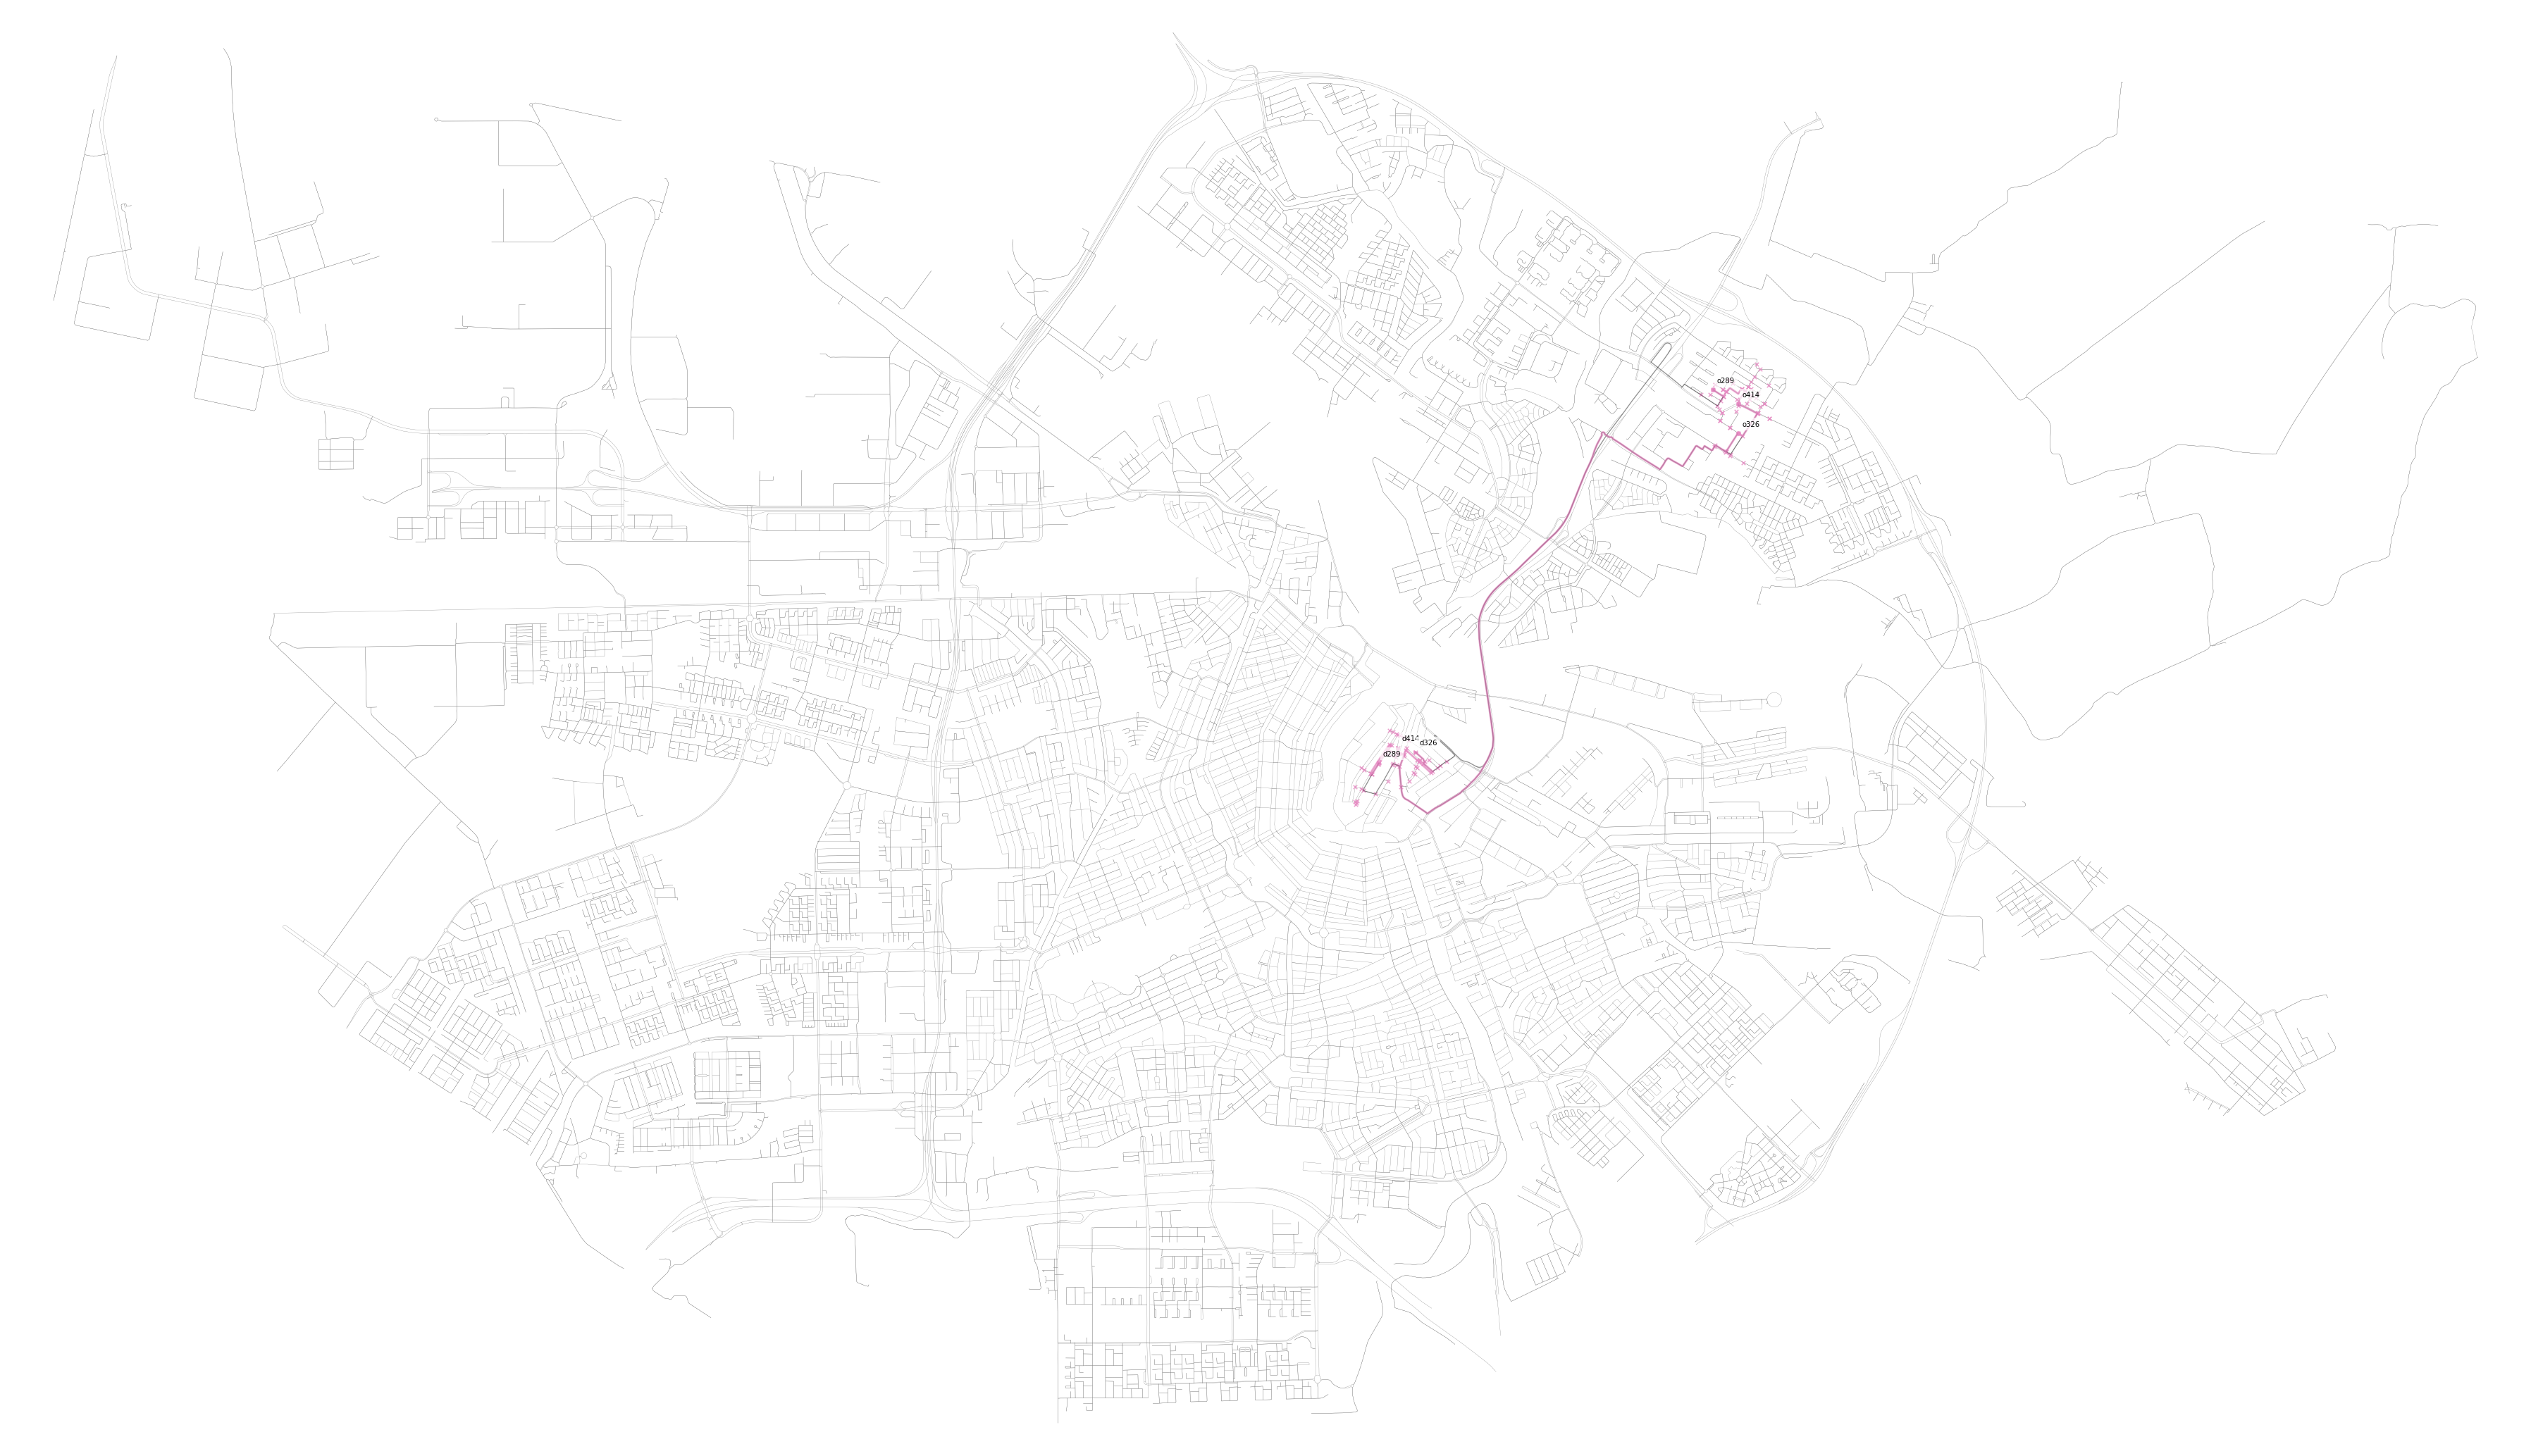

In [90]:
plot_map_rides(inData, ride['index'], light=False, m_size=30, lw=3, fontsize = 10, figsize = (50,50))

In [92]:
if len(ride.indexes==2):
    print(len(inData.pudo.loc[ride.indexes.iloc[0][0]].origin_nodes)*len(inData.pudo.loc[ride.indexes.iloc[0][1]].origin_nodes)*len(inData.pudo.loc[ride.indexes.iloc[0][0]].destination_nodes)\
*len(inData.pudo.loc[ride.indexes.iloc[0][1]].destination_nodes))
elif len(ride.indexes==3):
        print(len(inData.pudo.loc[ride.indexes.iloc[0][0]].origin_nodes)*len(inData.pudo.loc[ride.indexes.iloc[0][1]].origin_nodes)*len(inData.pudo.loc[ride.indexes.iloc[0][0]].destination_nodes)\
*len(inData.pudo.loc[ride.indexes.iloc[0][1]].destination_nodes)*len(inData.pudo.loc[ride.indexes.iloc[0][2]].origin_nodes)*len(inData.pudo.loc[ride.indexes.iloc[0][2]].destination_nodes))

else:
        print(len(inData.pudo.loc[ride.indexes.iloc[0][0]].origin_nodes)*len(inData.pudo.loc[ride.indexes.iloc[0][1]].origin_nodes)*len(inData.pudo.loc[ride.indexes.iloc[0][0]].destination_nodes)\
*len(inData.pudo.loc[ride.indexes.iloc[0][1]].destination_nodes)*    len(inData.pudo.loc[ride.indexes.iloc[0][2]].origin_nodes)*len(inData.pudo.loc[ride.indexes.iloc[0][3]].origin_nodes)*len(inData.pudo.loc[ride.indexes.iloc[0][2]].destination_nodes)\
*len(inData.pudo.loc[ride.indexes.iloc[0][3]].destination_nodes))

162000


In [96]:
for i,r in ride.iterrows():
    graph = ride_to_pudo_graph(r)
    if len(ride.indexes==2):
        a_0   = two_degree_pudo_exh(graph, r)
        a_1   = two_degree_pudo(graph, r, limit =100000)
    elif len(ride.indexes==3):
        a_0   = three_degree_pudo_exh(graph, r)
        a_1   = three_degree_pudo(graph, r, limit =100000)
        
    elif len(ride.indexes==4):
        a_0   = four_degree_pudo_exh(graph, r)
        a_1   = four_degree_pudo(graph, r, limit =100000)



    d_0 = {'exact-distances':a_0[0],
        'exact-predecessors': a_0[1]}
    
    d_1 = {'heuristic-distances': a_1[0],
        'heuristic-predecessors':a_1[1]}
    df_0 = pd.DataFrame(data=d_0, columns = ['exact-distances', 'exact-predecessors'])
    df_1 = pd.DataFrame(data=d_1, columns = ['heuristic-distances','heuristic-predecessors'])

    df_ = pd.concat([df_0,df_1],\
                       ignore_index=True, axis=1)
    df_.columns=['exact-distances', 'exact-predecessors','heuristic-distances','heuristic-predecessors']
    df_.to_csv(r"C:\Users\mmari\Desktop\MARKO STUFF\UNI\MSc\2nd Transport & Planning\Thesis\Codes\ExMAS\ExMAS\data\exactvsheur\{}-deg-{}-index.csv".format(len(r.indexes),r['index'])\
          ,sep=';')

In [183]:
print('{}-deg-{}-index'.format(len(r.indexes),r['index']))

2-deg-584-index


In [197]:
df_.to_csv(r"C:\Users\mmari\Desktop\MARKO STUFF\UNI\MSc\2nd Transport & Planning\Thesis\Codes\ExMAS\ExMAS\data\exactvsheur\{}-deg-{}-index.csv".format(len(r.indexes),r['index'])\
          ,sep=';')

In [64]:
idx   = np.argwhere(np.diff(np.sign(y01 - y02))).flatten()

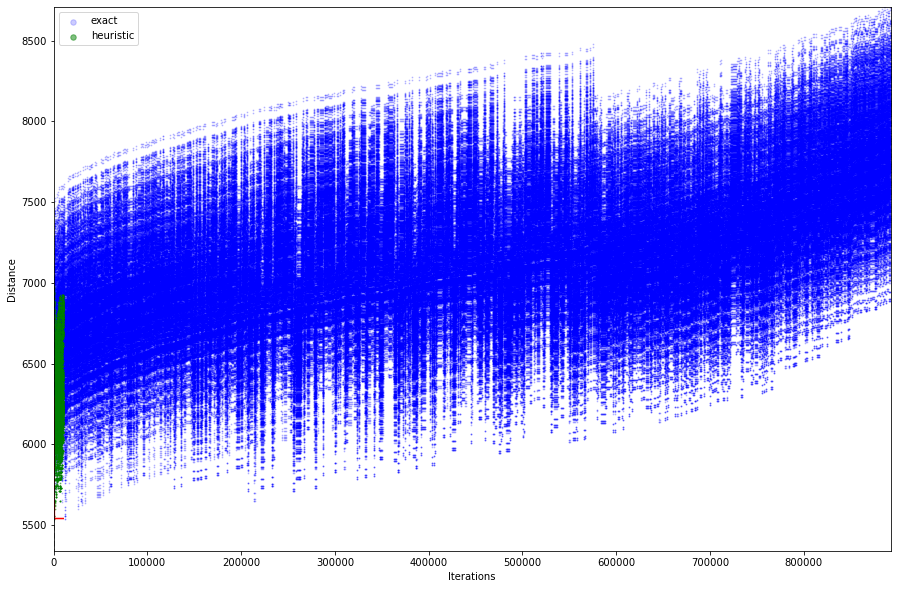

In [130]:
y01   = a_0[0]
y02   = a_0[1]
y11   = a_1[0]
y12   = a_1[1]
x0    = range(len(y01))
x1    = range(len(y11))
idx   = np.argwhere(np.diff(np.sign(y11 - y12))).flatten()


lines = []
# for i,dx in enumerate(idx):
#     pair = [((dx,0),(dx,y12[i]))]
#     lines.append(pair)
max_heur = np.where(a_1[0]==max(a_1[0]))[0][0]
lines.append(((max_heur,0),(max_heur,max(a_1[0]))))
             
linecoll = matcoll.LineCollection(lines, colors ='k', linestyle = '--',alpha=0.6)
fig, ax = plt.subplots(figsize=(15,10))
ax.add_collection(linecoll)

plt.scatter(x0, y01, s = 0.8, c = 'b', alpha = 0.2,marker = 'o' ,label = 'exact')
plt.scatter(x1, y11, s = 0.8, c = 'g', alpha = 0.5,marker = 'o' ,label = 'heuristic')

#plt.plot(x0, y02, c ='r', label = '')
plt.plot(x1, y12, c ='r', label = '')

lgnd = plt.legend(scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]

plt.ylabel('Distance')
plt.xlabel('Iterations')
#plt.xticks(range(0,max(x0),10000))
plt.ylim(min(y02)-200,max(y01))
plt.xlim(0,max(x0))
plt.show()

In [101]:
pd.read_csv("C:\Users\mmari\Desktop\MARKO STUFF\UNI\MSc\2nd Transport & Planning\Thesis\Codes\ExMAS\ExMAS\data\exactvsheur\2-deg-774-index.csv")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-101-7bfbd07c9737>, line 1)

In [121]:
cwd2 = os.getcwd()

In [120]:
os.chdir(os.path.join(cwd2,'ExMAS\data\exactvsheur'))

In [126]:
pd.read_csv('2-deg-774-index.csv', delimiter = ';', header=0, index_col=0)

,exact-distances,exact-predecessors,heuristic-distances,heuristic-predecessors
0,1994.0,1994.0,1994.0,1994.0
1,2050.0,1994.0,1993.0,1994.0
2,2056.0,1994.0,1993.0,1993.0
3,2122.0,1994.0,2049.0,1993.0
4,2188.0,1994.0,1994.0,1993.0
...,...,...,...,...
534745,5131.0,1993.0,NaN,NaN
534746,5225.0,1993.0,NaN,NaN
534747,5226.0,1993.0,NaN,NaN
534748,5278.0,1993.0,NaN,NaN
